# Strategy SARSA

> CRLD SARSA agents in strategy space  

SARSA agents take into acount the five pieces of information of current State, current Action, Reward, next State and next Action.

In [ ]:
#| default_exp Agents/StrategySARSA

In [ ]:
#| hide
# Imports for the nbdev development environment
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example

In [ ]:
from pyCRLD.Agents.StrategySARSA import stratSARSA
from pyCRLD.Agents.StrategyActorCritic import stratAC

from pyCRLD.Environments.SocialDilemma import SocialDilemma
from pyCRLD.Utils import FlowPlot as fp

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
env = SocialDilemma(R=1.0, T=0.8, S=-0.5, P=0.0)

Let's compare the SARSA (in red) with the actor-critic learners (in blue). The difference is that the SARSA learners incorporate an explicit exploration term in their learning update, regulated by the `choice_intensities`. For low choice intensities, the SARSA learners tend to extreme exploration, i.e., toward the center of the strategy space. For high choice intensities, the SARSA map onto the actor-critic learners (see Figure below). For the actor-critic learners, the `choice_intensities` have no effect other than scaling the learning speed alongside the learning rates. 

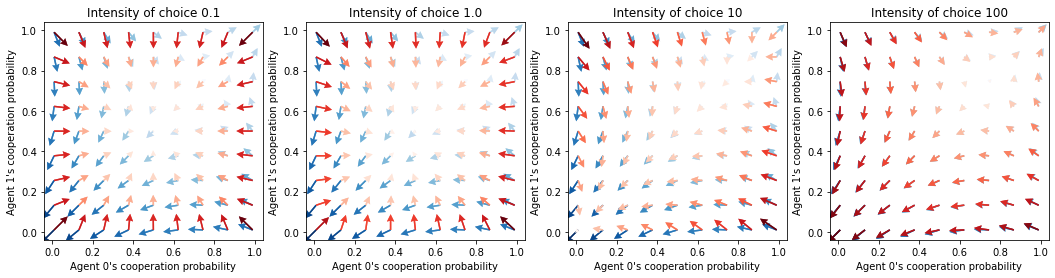

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(18,4))
faps = np.linspace(0.01 ,0.99, 9)
x = ([0], [0], [0])
y = ([1], [0], [0])

for i, ci in enumerate([0.1, 1.0, 10, 100]):

    maeiAC = stratAC(env=env, learning_rates=0.1, discount_factors=0.9, choice_intensities=ci)
    maeiSARSA = stratSARSA(env=env, learning_rates=0.1, discount_factors=0.9, choice_intensities=ci)

    fp.plot_strategy_flow(maeiAC, x, y, flowarrow_points=faps, cmap="Blues", axes=[ax[i]])
    fp.plot_strategy_flow(maeiSARSA, x, y, flowarrow_points=faps, cmap="Reds", axes=[ax[i]]);

    ax[i].set_xlabel("Agent 0's cooperation probability")
    ax[i].set_ylabel("Agent 1's cooperation probability")
    ax[i].set_title("Intensity of choice {}".format(ci));

## API

In [ ]:
#| export
import numpy as np
import itertools as it
from functools import partial

import jax
from jax import jit
import jax.numpy as jnp

from fastcore.utils import *

from pyCRLD.Agents.StrategyBase import strategybase
from pyCRLD.Utils.Helpers import *

In [ ]:
#| export   
class stratSARSA(strategybase):
    """
    Class for CRLD-SARSA agents in strategy space.
    """
    
    @partial(jit, static_argnums=(0,2))
    def RPEisa(self,
               Xisa,  # Joint strategy
               norm=False # normalize error around actions? 
               ) -> np.ndarray:  # RP/TD error
        """
        Compute reward-prediction/temporal-difference error for 
        strategy SARSA dynamics, given joint strategy `Xisa`.
        """
        R = self.Risa(Xisa)
        NextQ = self.NextQisa(Xisa, Risa=R)

        n = jnp.newaxis
        E = self.pre[:,n,n]*R + self.gamma[:,n,n]*NextQ - 1/self.beta * jnp.log(Xisa)
        E *= self.beta[:,n,n]

        E = E - E.mean(axis=2, keepdims=True) if norm else E
        return E
    
    @partial(jit, static_argnums=0)
    def NextQisa(self,
                 Xisa,          # Joint strategy
                 Qisa=None,  # Optional state-action values for speed-up
                 Risa=None,  # Optional rewards for speed-up
                 Vis=None,   # Optional state values for speed-up
                 Tisas=None  # Optional transition for speed-up
                ) -> jnp.ndarray: # Next values       
        """
        Compute strategy-average next state-action value for agent `i`, current state `s` and action `a`.
        """
        Qisa = self.Qisa(Xisa, Risa=None, Vis=None, Tisas=None)\
            if Qisa is None else Qisa
        
        i = 0; a = 1; s = 2; s_ = 3
        j2k = list(range(6, 6+self.N-1))  # other agents
        b2d = list(range(6+self.N-1, 6+self.N-1 + self.N))  # all actions
        e2f = list(range(5+2*self.N, 5+2*self.N + self.N-1))  # all other acts

        sumsis = [[j2k[l], s, e2f[l]] for l in range(self.N-1)]  # sum inds
        otherX = list(it.chain(*zip((self.N-1)*[Xisa], sumsis)))

        NextQis = jnp.einsum(Qisa, [i, s_, a], Xisa, [i, s_, a], [i, s_])
                    
        args = [self.Omega, [i]+j2k+[a]+b2d+e2f] + otherX +\
            [self.T, [s]+b2d+[s_], NextQis, [i, s_], [i, s, a]]                                            
        return jnp.einsum(*args, optimize=self.opti)


In [ ]:
show_doc(stratSARSA.RPEisa)

---

### stratSARSA.RPEisa

>      stratSARSA.RPEisa (Xisa, norm=False)

Compute reward-prediction/temporal-difference error for 
strategy SARSA dynamics, given joint strategy `Xisa`.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| Xisa |  |  | Joint strategy |
| norm | bool | False | normalize error around actions? |
| **Returns** | **ndarray** |  | **RP/TD error** |

In [ ]:
show_doc(stratSARSA.NextQisa)

---

### stratSARSA.NextQisa

>      stratSARSA.NextQisa (Xisa, Qisa=None, Risa=None, Vis=None, Tisas=None)

Compute strategy-average next state-action value for agent `i`, current state `s` and action `a`.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| Xisa |  |  | Joint strategy |
| Qisa | NoneType | None | Optional state-action values for speed-up |
| Risa | NoneType | None | Optional rewards for speed-up |
| Vis | NoneType | None | Optional state values for speed-up |
| Tisas | NoneType | None | Optional transition for speed-up |
| **Returns** | **Array** |  | **Next values** |

Note, that although `stratSARSA.NextQisa` is computed differently than `stratAC.NextVisa`, they give actually identical values.

In [ ]:
ci = 100 * np.random.rand()

maeAC = stratAC(env=env, learning_rates=0.1, discount_factors=0.9, choice_intensities=ci)
maeSARSA = stratSARSA(env=env, learning_rates=0.1, discount_factors=0.9, choice_intensities=ci)

X = maeAC.random_softmax_strategy()

assert np.allclose(maeAC.NextVisa(X) - maeSARSA.NextQisa(X), 0, atol=1e-05)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()